In [53]:
import os
import numpy as np
from joblib import load
from datetime import datetime, timedelta
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, MimeType
import rasterio
import matplotlib.pyplot as plt

# Load the pre-trained anomaly detection model
model_path = "isolation_forest_model.joblib"
ais_model = load(model_path)

# Define function to generate a bounding box
def generate_bbox(lat, lon, degree_offset=0.1):
    """
    Generate a bounding box around a given latitude and longitude.
    """
    return {
        "lon_min": lon - degree_offset,
        "lat_min": lat - degree_offset,
        "lon_max": lon + degree_offset,
        "lat_max": lat + degree_offset,
    }

# Define function to calculate start and end date
def calculate_date_range(timestamp, days_offset=2):
    """
    Generate start and end dates around a given timestamp.
    """
    anomaly_date = datetime.strptime(timestamp, "%Y-%m-%d")
    start_date = (anomaly_date - timedelta(days=days_offset)).strftime("%Y-%m-%d")
    end_date = (anomaly_date + timedelta(days=days_offset)).strftime("%Y-%m-%d")
    return start_date, end_date

# Function to generate a SAR GRD image
def generate_grd_image(lon_min, lat_min, lon_max, lat_max, start_date, end_date, client_id, client_secret, data_folder):
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret

    bbox = BBox(bbox=[lon_min, lat_min, lon_max, lat_max], crs=CRS.WGS84)

    request = SentinelHubRequest(
        evalscript="""
            function setup() {
                return {
                    input: ["VV"],
                    output: { bands: 1, sampleType: "FLOAT32" }
                };
            }
            function evaluatePixel(sample) {
                return [sample.VV];
            }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW,
                time_interval=(start_date, end_date),
                mosaicking_order='mostRecent'
            )
        ],
        responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
        bbox=bbox,
        size=(1024, 1024),
        data_folder=data_folder,
        config=config
    )

    try:
        images = request.get_data(save_data=True)
        image_path = os.path.join(data_folder, 'response_grd.tiff')
        print(f"GRD Image downloaded and saved at: {image_path}")

        # Display the image
        with rasterio.open(image_path) as dataset:
            grd_image = dataset.read(1)

        plt.figure(figsize=(10, 10))
        plt.imshow(grd_image, cmap='gray', interpolation='nearest')
        plt.colorbar(label="Intensity")
        plt.title("Sentinel-1 GRD (VV Polarization)")
        plt.show()

    except Exception as e:
        print("Error occurred while fetching the data:", str(e))

# Sentinel Hub credentials
client_id = 'db6f06cb-d661-439b-8942-71691e39c83b'
client_secret = 'KOZnydqNMtb6i1czu6mLiTXrV1D4u1xe'
data_folder = './SAR_Images'

# Ensure the folder exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

### FINAL CODE

Fetched image data: [array([[0.0065187 , 0.00921569, 0.00492349, ..., 0.01145793, 0.01386655,
        0.01287033],
       [0.00828333, 0.00695974, 0.00613055, ..., 0.011923  , 0.00840173,
        0.00645605],
       [0.00570909, 0.00381249, 0.0031244 , ..., 0.01288288, 0.00609826,
        0.00505079],
       ...,
       [0.00645719, 0.00608845, 0.00802608, ..., 0.018907  , 0.0082594 ,
        0.01096041],
       [0.00885856, 0.00537683, 0.0097311 , ..., 0.01239908, 0.00438636,
        0.01191832],
       [0.00886007, 0.01063529, 0.00405756, ..., 0.01656426, 0.01185953,
        0.00778917]], dtype=float32)]
Type of the data: <class 'list'>
Shape of image data: (1024, 1024)


2024-12-11 03:11:46,705 - WARNING - 6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021F1314A840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


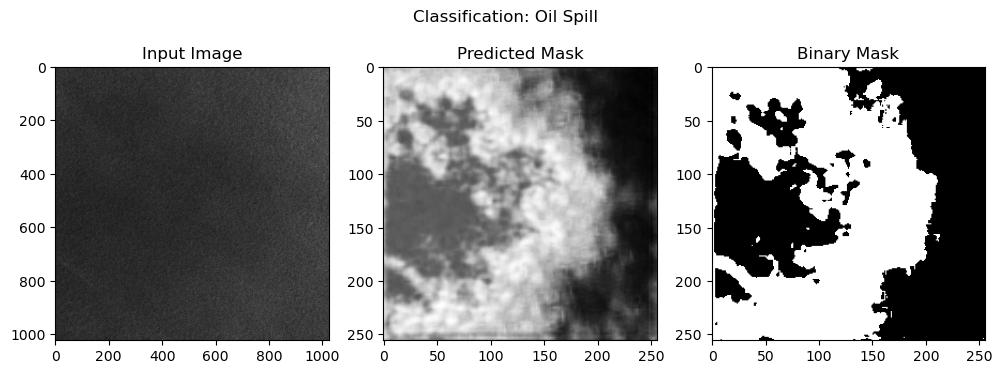

Classification: Oil Spill
Fetched image data: [array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)]
Type of the data: <class 'list'>
Shape of image data: (1024, 1024)


C:\Users\ravik\AppData\Local\Temp\ipykernel_22876\238485747.py:146: RuntimeWarning: invalid value encountered in cast
  image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


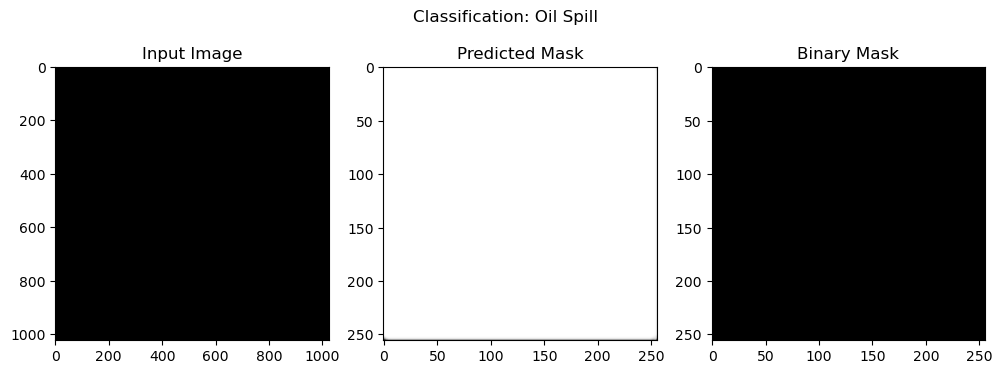

Classification: Oil Spill


In [76]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
import io
from datetime import datetime, timedelta
from sentinelhub import SHConfig, SentinelHubRequest, MimeType, CRS, BBox, DataCollection

# Load the trained model
model = load_model('unet_final_model.keras')

def preprocess_image(image, image_size=(256, 256)):
    """
    Preprocess the input image: resize and normalize.
    """
    image = cv2.resize(image, image_size) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(np.expand_dims(image, axis=-1), axis=0)  # Add batch and channel dimensions

def convert_tiff_to_jpg_in_memory(tiff_image):
    """
    Convert the input TIFF image to JPG format in memory and return it.
    """
    # Convert to RGB mode (JPEG does not support transparency)
    img = tiff_image.convert('RGB')
    # Save the image to a bytes buffer instead of a file
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')
    img_byte_arr.seek(0)
    # Open the image from the byte array using OpenCV
    img_array = np.asarray(bytearray(img_byte_arr.read()), dtype=np.uint8)
    return cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)  # Decode as grayscale

# Function to classify oil spill
def classify_oil_spill(image, threshold=0.5, spill_pixel_ratio=0.01):
    """
    Classify whether the input image contains an oil spill or not.
    """
    # Preprocess the image
    processed_image = preprocess_image(image)
    
    # Predict the mask
    predicted_mask = model.predict(processed_image)[0]
    
    # Threshold the mask
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    
    # Calculate spill pixel ratio
    spill_pixels = np.sum(binary_mask)
    total_pixels = binary_mask.size
    spill_ratio = spill_pixels / total_pixels
    
    # Determine classification
    classification = "Oil Spill" if spill_ratio > spill_pixel_ratio else "Non Oil Spill"
    
    # Display results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask.squeeze(), cmap='gray')
    plt.title("Binary Mask")
    
    plt.suptitle(f"Classification: {classification}")
    plt.show()
    
    print(f"Classification: {classification}")

# Function to generate bounding box
def generate_bbox(lat, lon, degree_offset=0.3):
    """
    Generate a bounding box around a given latitude and longitude.
    """
    return {
        "lon_min": lon - degree_offset,
        "lat_min": lat - degree_offset,
        "lon_max": lon + degree_offset,
        "lat_max": lat + degree_offset,
    }

# Function to calculate start and end date
def calculate_date_range(timestamp, days_offset=2):
    """
    Generate start and end dates around a given timestamp.
    """
    anomaly_date = datetime.strptime(timestamp, "%Y-%m-%d")
    start_date = (anomaly_date - timedelta(days=days_offset)).strftime("%Y-%m-%d")
    end_date = (anomaly_date + timedelta(days=days_offset)).strftime("%Y-%m-%d")
    return start_date, end_date

# Function to generate a SAR GRD image
def generate_grd_image(lon_min, lat_min, lon_max, lat_max, start_date, end_date, client_id, client_secret, data_folder, response_counter):
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret

    bbox = BBox(bbox=[lon_min, lat_min, lon_max, lat_max], crs=CRS.WGS84)

    request = SentinelHubRequest(
        evalscript="""
            function setup() {
                return {
                    input: ["VV"],
                    output: { bands: 1, sampleType: "FLOAT32" }
                };
            }
            function evaluatePixel(sample) {
                return [sample.VV];
            }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW,
                time_interval=(start_date, end_date),
                mosaicking_order='mostRecent'
            )
        ],
        responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
        bbox=bbox,
        size=(1024, 1024),
        data_folder=data_folder,  # Use the correct folder path directly
        config=config
    )

    try:
        images = request.get_data(save_data=True)
        
        # Debugging: Print out the structure of the images variable
        print("Fetched image data:", images)
        print("Type of the data:", type(images))
        
        # Directly work with the NumPy array
        if isinstance(images, list) and len(images) > 0:
            image_data = images[0]  # The first element is the image data
            print("Shape of image data:", image_data.shape)
            
            # Convert NumPy array to OpenCV image
            image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            # Convert the image to JPG in memory and classify oil spill
            jpg_image = convert_tiff_to_jpg_in_memory(Image.fromarray(image))
            classify_oil_spill(jpg_image)

        else:
            print("No valid image data received.")
    
    except Exception as e:
        print("Error occurred while fetching the data:", str(e))

# Sentinel Hub credentials
client_id = 'db6f06cb-d661-439b-8942-71691e39c83b'
client_secret = 'KOZnydqNMtb6i1czu6mLiTXrV1D4u1xe'
data_folder = './SAR_Images'

# Ensure the folder exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Example anomaly data (replace with actual data)
anomalies = [
    {"lat": -20, "lon": 55, "timestamp": "2020-07-29"},
    {"lat": 16, "lon": 118, "timestamp": "2024-07-25"}
]

# Automatically process anomalies
response_counter = 1
for anomaly in anomalies:
    lat = anomaly["lat"]
    lon = anomaly["lon"]
    timestamp = anomaly["timestamp"]
    
    # Generate bounding box and date range
    bbox = generate_bbox(lat, lon)
    start_date, end_date = calculate_date_range(timestamp)
    
    # Generate GRD image and classify oil spill
    generate_grd_image(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"], start_date, end_date, client_id, client_secret, data_folder, response_counter)
    
    # Increment the counter for the next image
    response_counter += 1
